## Problem Definition

Given a set of features that happened in a round of CS:GO match, how well can we predict which team would win a round?

## Data

https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification/code?select=csgo_round_snapshots.csv

## Evaluation

A baseline of 80% accuracy

In [142]:
# Packages for analysis and data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [158]:
df = pd.read_csv('csgo_round_snapshots.csv')

In [152]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [116]:
df.round_winner.value_counts()

T     62406
CT    60004
Name: round_winner, dtype: int64

<Axes: >

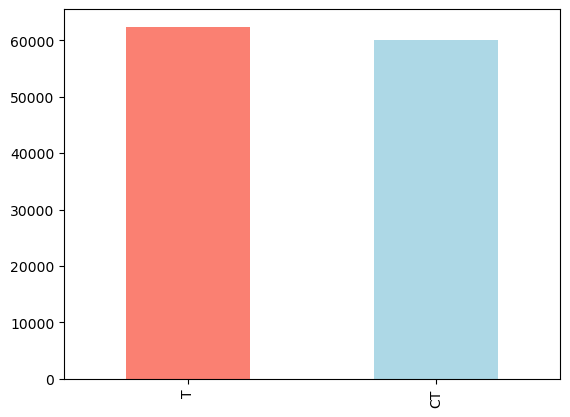

In [89]:
df.round_winner.value_counts().plot(kind='bar', color=['salmon', 'lightblue'])

Just by looking at this graph, we can say that it is a balanced dataset

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

In [92]:
np.sum(np.sum(df.isna()))

0

There seems to be no missing values in the data and most of them are in the right formats except for map, bomb_planted and round_winner. 

In [94]:
df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


In [95]:
df.drop(df.select_dtypes(np.number), axis=1)

,map,bomb_planted,round_winner
0,de_dust2,False,CT
1,de_dust2,False,CT
2,de_dust2,False,CT
3,de_dust2,False,CT
4,de_dust2,False,CT
...,...,...,...
122405,de_train,True,T
122406,de_train,False,T
122407,de_train,False,T
122408,de_train,False,T


Lets first convert the columns into numbers. These three are the only categorical columns in the data that we need to convert.

We can simply change the data type of bomb_planted since its a boolean value, but for the others, we would need to use Label Encoder

In [159]:
df['bomb_planted'] = df['bomb_planted'].astype(np.int16)

In [160]:
encoder = LabelEncoder()

df['map'] = encoder.fit_transform(df['map'])
df['round_winner'] = encoder.fit_transform(df['round_winner'])

In [119]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [161]:
df_scaled = df

Everything is now encoded in numbers

Now we need to scale our data that is standard across the dataset. The reason why we need to scale our data is because we don't want our model to be heavily influenced by features that are in large values compared to other features that might be lower.

In [164]:
y = df_scaled['round_winner']
df_X = df_scaled.drop('round_winner', axis=1)

In [165]:
scaler = RobustScaler()
X = scaler.fit_transform(df_X)

X = pd.DataFrame(X)
X.columns = df_X.columns

Now that we've already scaled down our data, let's first try to fit the data into our logistic regression model without doing any further pre-processing just to see how well it does

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [168]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

/Users/bastymvergara/Desktop/heart-disease-project/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7434850093946573

As we can see, as a starting point, our model scored 74%. In other words, our model can correctly predict who would win 74% of the time.

## Principle Component Analysis (PCA)

Initially, we trained our model on the entire dataset, meaning we used all 96 columns. In this simple analysis, 96 columns might be too many features, and its possible that we also don't need some of the features or maybe some of them are redundant. For the purpose of this analysis, let's try experimenting with PCA (Principle Component Analysis)!

So what is PCA even? Simply put, PCA is a dimensionality reduction technique that takes your old dataset, and transforms it into a new dataset, while maintaining the most variance from the original dataset. In other words, it creates a new dataset from your old dataset, while still maintaining all the important information.

There are two ways I do PCA and to determine how many components I should use:
1. Using the whole dataset and all of its features, check the plot of the explained variance ratio and see where it captures at least 95% variance
2. Use the helper function and it gives you the number of components needed

In [226]:
# First make sure that you are using a new set of X and y

y = df_scaled['round_winner']
df_X = df_scaled.drop('round_winner', axis=1)

scaler = RobustScaler()
X = scaler.fit_transform(df_X)

In [227]:
# This is where we instantiate our PCA using 96 components (which is the number of columns we have) 
# then fit it to our X data
pca = PCA(n_components=96).fit(X)

Text(0, 0.5, 'cumulative explained variance')

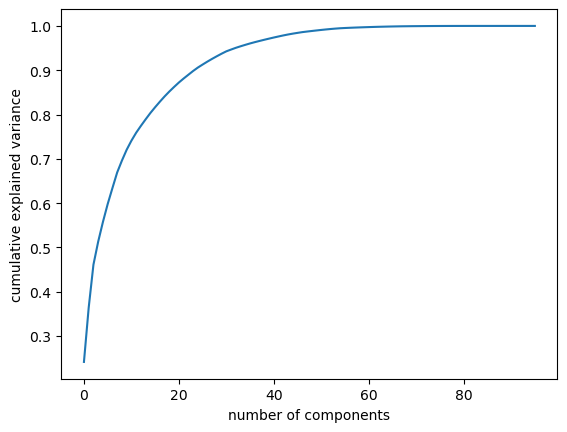

In [228]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Here's the first way to determine how many components we should we using for PCA. Basically, you need to determine the point where the line creates an elbow and gives you at least 95% of the variance. 95% variance is not a rule of thumb, and it depends on your own context, but I generally use it. While this approach may give you the answer, I personally find it a bit tricky to find the right number of components, and so I use a helper function instead

In [229]:
def getKComponents(pca, alpha):
    total_variance = 0
    for feature, variance in enumerate(pca.explained_variance_ratio_):
        total_variance += variance
        if (total_variance >= 1 - alpha):
            return feature + 1
    return len(pca.explained_variance_ratio)

In [230]:
K = getKComponents(pca, 0.05)
K

33

According to the function, the number of components that we should use that will give us at least 95% of the variance of the data is 33. Now we just need to transform our data using the specified number of components (features)

In [231]:
X = pca.transform(X)[:, 0:K]

In [250]:
X.columns = df_X.iloc[:, :33].columns
X

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar
0,0.807650,-3.041170,-0.477923,-0.788150,-0.837791,0.305314,-0.571604,-0.640431,0.391012,-0.089662,...,-0.406736,-0.220961,0.062492,-0.033852,-0.065296,0.007777,-0.080869,-0.049944,-0.165961,0.056775
1,0.403354,-2.516566,-0.271932,-1.210600,-0.940974,0.463845,-0.769151,-0.302018,-0.226065,-0.320548,...,-0.424848,0.001105,0.020463,0.051323,0.030929,-0.023390,0.045672,-0.006290,0.185634,0.072155
2,1.793312,-1.452247,-0.282613,-1.090443,-0.785376,0.333237,-0.704440,-0.376257,0.147196,-0.330615,...,0.156083,0.008170,-0.026589,0.010115,0.146338,-0.054307,0.084381,-0.020325,0.149910,0.107855
3,1.953921,-1.452769,-0.437852,-1.067899,-0.855280,0.367944,-0.569773,-0.317184,0.120949,-0.332918,...,0.102953,0.022223,0.006126,0.070663,0.069446,-0.048108,0.049091,-0.094075,0.219295,-0.199274
4,0.531003,-3.044842,-0.766788,-0.128865,-0.392524,0.306517,-0.459914,-0.600220,0.627068,-0.421338,...,-0.332748,-0.130514,-0.103789,0.085502,-0.007072,-0.034536,0.101459,-0.186271,0.057514,-0.024417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,2.662008,1.291910,1.542080,0.772222,-0.739458,-0.647647,0.687017,-0.644861,-1.184389,0.700592,...,0.002813,0.159939,0.097054,-0.472091,-0.097370,-0.511502,-0.017211,-0.110692,-0.203674,0.171138
122406,-0.110277,-2.209320,0.228796,1.364919,-0.437793,-0.861938,-0.019721,0.045146,-0.401692,0.860939,...,0.229384,0.662024,0.323117,-0.426443,-0.007367,-0.088607,0.094928,0.059359,-0.130469,0.205325
122407,-2.375611,0.942436,1.160162,-0.669273,1.450319,1.070238,0.582792,0.596464,-1.143166,1.541248,...,0.833349,0.424366,-0.131201,0.113948,-0.116364,-0.103917,0.191911,-0.500739,-0.255426,0.079432
122408,-1.905041,0.618990,1.723658,-0.066840,0.992627,1.524162,0.628238,0.485320,-1.258091,1.679712,...,0.700360,0.455182,-0.235973,0.224711,-0.127013,-0.221656,0.129971,-0.494348,-0.006301,-0.281792


## Model Training

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [253]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.7440568580998285

It seems that even after applying PCA to our data, we still got a 74% score, which is the same from our initial score even without applying PCA.

Let's try to hypertune our model further to see if we can improve the scores

## Hypertuning 

In [254]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [255]:
gs_log_reg.best_params_

{'C': 0.0018329807108324356, 'solver': 'liblinear'}

In [256]:
gs_log_reg.score(X_test, y_test)

0.745649865207091

After applying GridSearchCV, our score became 75%

In [257]:
# Make predictions on test data
y_preds = gs_log_reg.predict(X_test)

In [258]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     11921
           1       0.76      0.74      0.75     12561

    accuracy                           0.75     24482
   macro avg       0.75      0.75      0.75     24482
weighted avg       0.75      0.75      0.75     24482



In [261]:
features_dict = dict(zip(X.columns, list(log_reg.coef_[0])))
features_dict

{'time_left': 0.12724916681239856,
 'ct_score': -0.07517899141972141,
 't_score': 0.9914035996288123,
 'map': -0.17306919975836665,
 'bomb_planted': 0.16507495179401288,
 'ct_health': -0.3000137207976168,
 't_health': 0.6074955438111771,
 'ct_armor': -1.1581519964014275,
 't_armor': -0.3143399018521442,
 'ct_money': -0.11374306469729925,
 't_money': 0.023512705617613802,
 'ct_helmets': 0.10777341302957937,
 't_helmets': -0.006259088992764887,
 'ct_defuse_kits': 0.13305340792043485,
 'ct_players_alive': -0.05738320094529452,
 't_players_alive': -0.160050164401989,
 'ct_weapon_ak47': 0.16747123251545828,
 't_weapon_ak47': -0.14852600455643747,
 'ct_weapon_aug': 0.07411550307399668,
 't_weapon_aug': 0.3082102686122811,
 'ct_weapon_awp': 0.24760166184285556,
 't_weapon_awp': -0.10749668783056344,
 'ct_weapon_bizon': -0.09532089590743094,
 't_weapon_bizon': -0.25202915463799835,
 'ct_weapon_cz75auto': -0.10135798630901856,
 't_weapon_cz75auto': 0.6709924988590781,
 'ct_weapon_elite': -0.499

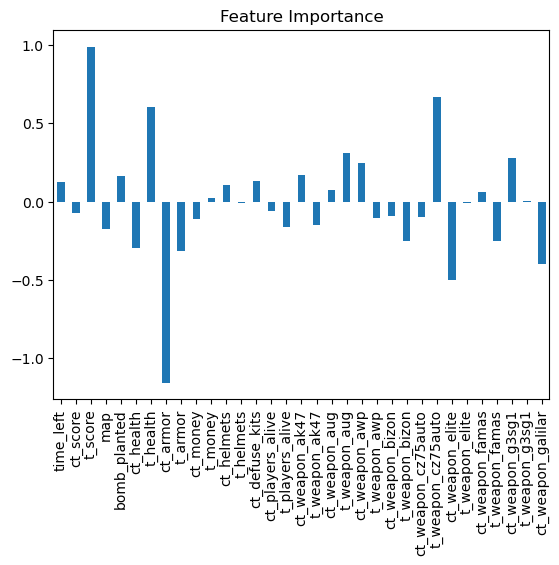

In [262]:
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.bar(title="Feature Importance", legend=False);

## Key Points

- Applying PCA or not still resulted to a 74% score on our data. Even after hypertuning the model, we still got a low score percentage. However, it is important to consider the different aspects of the game such as the human aspect of it and the potential comebacks. 
- There are still some other ways to improve the model. Perhaps using a different model might give a better score